In [2]:
import mmml
import matplotlib.pyplot as plt
import patchworklib as pw
import os
from pathlib import Path
import numpy as np
os.environ["XLA_PYTHON_CLIENT_MEM_FRACTION"] = "0.95"
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
import jax
devices = jax.local_devices()
print(devices)
print(jax.default_backend())
print(jax.devices())

[CudaDevice(id=0)]
gpu
[CudaDevice(id=0)]


In [3]:
from mmml import dcmnet

In [4]:
import jax

from mmml.dcmnet.dcmnet.data import prepare_datasets
from mmml.dcmnet.dcmnet.modules import MessagePassingModel
from mmml.dcmnet.dcmnet.training import train_model, train_model_dipo

key = jax.random.PRNGKey(0)


In [5]:
NDCM = 7
model = MessagePassingModel(
    features=32, max_degree=2, num_iterations=2,
    num_basis_functions=32, cutoff=4.0, n_dcm=NDCM,
    include_pseudotensors=False,
)

## Data

In [6]:
current_path = Path.cwd()
print(current_path)
data_path = Path("/mnt/d/data")
data_files = list(data_path.glob("*npz"))
for i in range(len(data_files)):
    print(i, data_files[i])

/home/ericb/mmml/notebooks/dcmnet
0 /mnt/d/data/240124_combined_water.npz
1 /mnt/d/data/Data_new.npz
2 /mnt/d/data/esp13415.npz
3 /mnt/d/data/esp2000.npz
4 /mnt/d/data/md17_ethanol.npz
5 /mnt/d/data/mulitpoles1000.npz
6 /mnt/d/data/mulitpoles10000.npz
7 /mnt/d/data/mulitpoles766000.npz
8 /mnt/d/data/qm9-combined.npz
9 /mnt/d/data/qm9-esp-dip-1000-0.npz
10 /mnt/d/data/qm9-esp-dip-1000-1.npz
11 /mnt/d/data/qm9-esp-dip-1000-2.npz
12 /mnt/d/data/qm9-esp-dip-1000-3.npz
13 /mnt/d/data/qm9-esp-dip-40000-0.npz
14 /mnt/d/data/qm9-esp-dip-40000-1.npz
15 /mnt/d/data/qm9-esp-dip-40000-2.npz
16 /mnt/d/data/qm9-esp-dip-6907-3.npz
17 /mnt/d/data/qm9-esp10000.npz
18 /mnt/d/data/qm9-esp1021.npz
19 /mnt/d/data/qm9-esp20000.npz
20 /mnt/d/data/qm9-esp40000-0.npz
21 /mnt/d/data/qm9-esp40000-1.npz
22 /mnt/d/data/qm9-esp40000-2.npz
23 /mnt/d/data/qm9-esp40000-39999.npz
24 /mnt/d/data/qm9-esp40000.npz
25 /mnt/d/data/qm9-esp6907-3.npz
26 /mnt/d/data/qm9-esp6907-6906.npz
27 /mnt/d/data/qm9-esp95289.npz
28 /mnt/

In [9]:
index = 30
data_path_resolved = data_files[index].resolve()
data_loaded = np.load(data_path_resolved, 
allow_pickle=True)
data_path_resolved

PosixPath('/mnt/d/data/spice2-esp-dip-1977-0.npz')

R
(1977, 60, 3)
Z
(1977, 60)


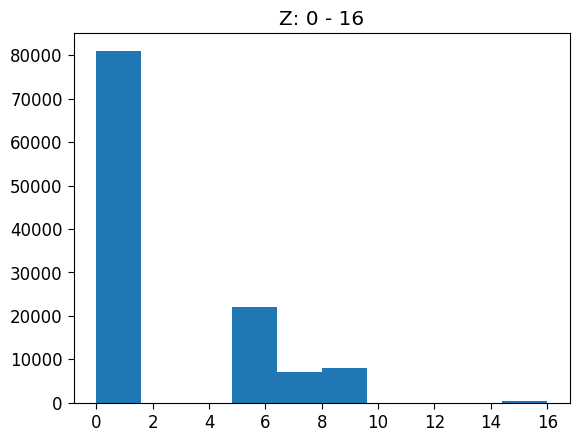

N
(1977,)


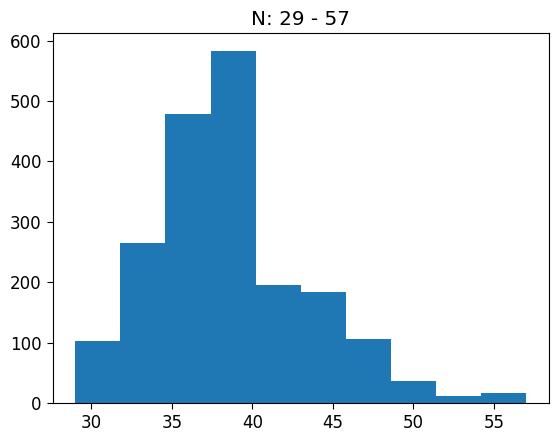

D
(1977,)


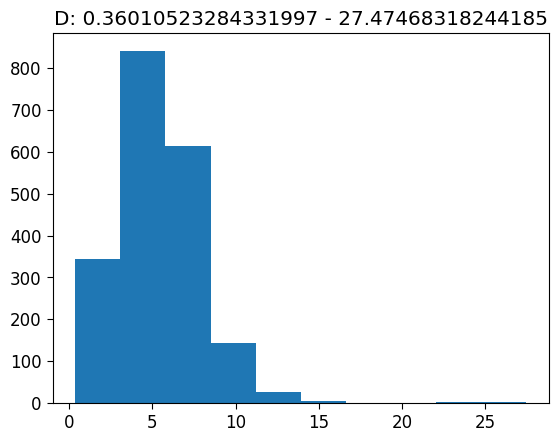

com
(1977, 3)


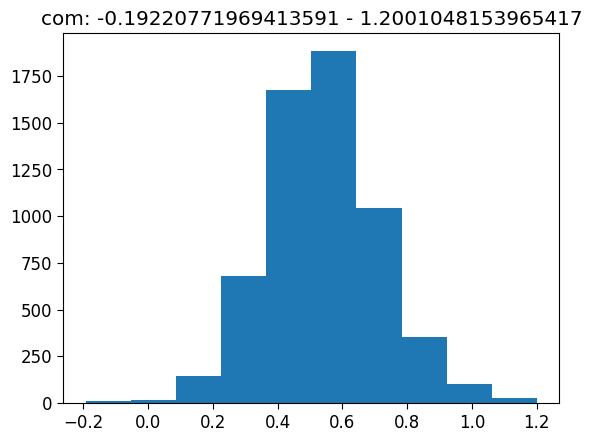

Dxyz
(1977, 3)


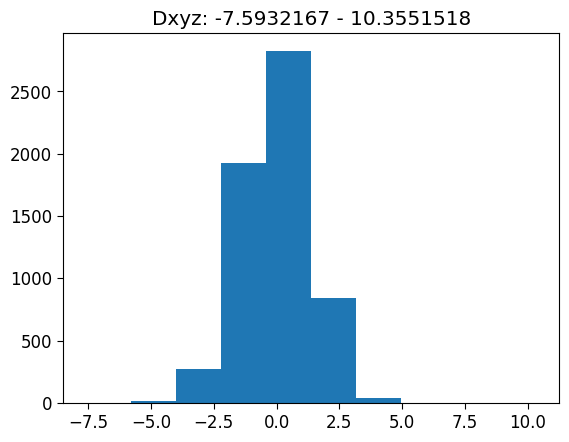

mono
(1977, 60, 1)
esp
(1977, 3200)


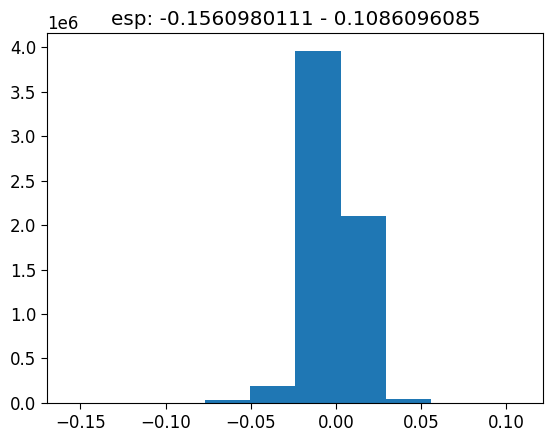

id
(1977,)
n_grid
(1977,)


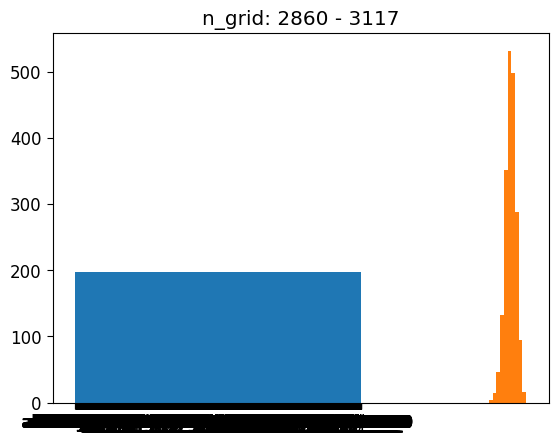

vdw_surface
(1977, 3200, 3)


In [38]:
for k in data_loaded.keys():
    print(k)
    shape = data_loaded[k].shape
    print(shape
    )
    if len(shape) < 3:
        try:
            d = data_loaded[k]
            d = d.flatten()
            plt.hist(d)
            title = f"{k}: {d.min()} - {d.max()}"
            plt.title(title)
            plt.show()
        except:
            pass

In [8]:
prepare_datasets?

Signature:
prepare_datasets(
    key,
    num_train,
    num_valid,
    filename,
    clean=False,
    esp_mask=False,
    clip_esp=False,
    natoms=60,
)
Docstring:
Prepare datasets for training and validation.

Wrapper function that calls prepare_multiple_datasets and then
creates train/validation splits and dictionaries.

Parameters
----------
key : jax.random.PRNGKey
    Random key for dataset shuffling
num_train : int
    Number of training samples
num_valid : int
    Number of validation samples
filename : str or list
    Filename(s) to load datasets from
clean : bool, optional
    Whether to filter failed calculations, by default False
esp_mask : bool, optional
    Whether to create ESP masks, by default False
clip_esp : bool, optional
    Whether to clip ESP to first 1000 points, by default False
natoms : int, optional
    Maximum number of atoms per system, by default 60

Returns
-------
tuple
    A tuple containing train_data and valid_data dictionaries
File:      ~/mmml/mmm

In [11]:
train_data, valid_data = prepare_datasets(
    key, num_train=1200, num_valid=100,
    filename=[data_path_resolved],
    clean= False, esp_mask=True,
    # clip_esp=True,
)




shape (1977, 60, 3)
D (1977,)
R (1977, 60, 3)
(1977,)
['id', 'R', 'Z', 'N', 'mono', 'esp', 'vdw_surface', 'n_grid', 'D', 'Dxyz', 'com', 'espMask']
1977
0 id 1977 (1977,)
1 R 1977 (1977, 60, 3)
2 Z 1977 (1977, 60)
3 N 1977 (1977, 1)
4 mono 1977 (1977, 60)
5 esp 1977 (1977, 3200)
6 vdw_surface 1977 (1977, 3200, 3)
7 n_grid 1977 (1977,)
8 D 1977 (1977, 1)
9 Dxyz 1977 (1977, 3)
10 com 1977 (1977, 3)
11 espMask 1977 (1977, 3200)


In [12]:
esp_data = train_data["esp"]
esp_data.shape

(1200, 3200)

## Training (1)

In [13]:
train_model?

Signature:     
train_model(
    key,
    model,
    train_data,
    valid_data,
    num_epochs,
    learning_rate,
    batch_size,
    writer,
    ndcm,
    esp_w=1.0,
    restart_params=None,
    *,
    loss_step_fn: Callable = <PjitFunction of <function train_step at 0x7516dcc37c70>>,
    eval_step_fn: Callable = <PjitFunction of <function eval_step at 0x7516dc96a170>>,
    optimizer_fn: Callable = <function <lambda> at 0x7516dc96b5b0>,
    use_ema: bool = True,
    ema_decay: float = 0.999,
    use_grad_clip: bool = False,
    grad_clip_norm: float = 2.0,
    log_extra_metrics: Optional[Callable] = <function _log_extra_metrics_none at 0x7516dc96b490>,
    save_best_params_with_ema: bool = True,
    extra_valid_args: dict = None,
    extra_train_args: dict = None,
)
Call signature: train_model(*args, **kwargs)
Type:           partial
String form:    functools.partial(<function train_model_general at 0x7516dc96b400>, loss_step_fn=<PjitFunction of <...> tra_metrics=<function _log_extr

In [14]:
new_params = None

params, valid_loss = train_model(
    key=key, model=model,
    writer=None,
    train_data=train_data, valid_data=valid_data,
    num_epochs=30, learning_rate=1e-3, batch_size=1,
    ndcm=model.n_dcm, esp_w=10000.0,
)



Preparing batches
..................
Epoch 1 train: 0.23816253244876862, valid: 0.3061198592185974, best: True
Epoch 2 train: 0.10627926141023636, valid: 0.1710512489080429, best: True
Epoch 3 train: 0.09781274944543839, valid: 0.09559832513332367, best: True
Epoch 4 train: 0.09303350001573563, valid: 0.08246792107820511, best: True
Epoch 5 train: 0.0836046040058136, valid: 0.07549986243247986, best: True
Epoch 6 train: 0.07854647189378738, valid: 0.06858368963003159, best: True
Epoch 7 train: 0.07617583870887756, valid: 0.06430666148662567, best: True
Epoch 8 train: 0.07417923957109451, valid: 0.06110362708568573, best: True
Epoch 9 train: 0.07124143838882446, valid: 0.057757362723350525, best: True
Epoch 10 train: 0.06530775874853134, valid: 0.05626565217971802, best: True
Epoch 11 train: 0.06519175320863724, valid: 0.05506417527794838, best: True
Epoch 12 train: 0.061543725430965424, valid: 0.05284809693694115, best: True
Epoch 13 train: 0.06032954901456833, valid: 0.051565393805503

In [15]:
params['params'].keys()



dict_keys(['Dense_0', 'Dense_1', 'Dense_2', 'Dense_3', 'Dense_4', 'Embed_0', 'MessagePass_0', 'MessagePass_1', 'TensorDense_0', 'element_bias'])

In [16]:
from mmml.dcmnet.dcmnet.analysis import dcmnet_analysis, prepare_batch

?dcmnet_analysis
?prepare_batch

<Figure size 640x480 with 0 Axes>

Signature: prepare_batch(path: pathlib.Path, index=0, data=None)
Docstring:
Prepare a single batch from data for analysis.

Parameters
----------
path : Path
    Path to the data file
index : int, optional
    Index of the data to prepare
data : dict, optional
    Data dictionary to use instead of loading from file
    
Returns
-------
dict
    Batch dictionary ready for model input
File:      ~/mmml/mmml/dcmnet/dcmnet/analysis.py
Type:      function

In [17]:
index

30

In [39]:
batch = prepare_batch(data_files[28], index=0)
batch['com'] = np.mean(batch['R'].T, axis=-1) # center of mass
batch["Dxyz"] = batch["R"] - batch["com"]
output = dcmnet_analysis(params, model, batch)
print(output["rmse_model_masked"]), print(output["rmse_model"])
output.keys()

dict_keys(['R', 'Z', 'N', 'D', 'com', 'Dxyz', 'mono', 'esp', 'id', 'n_grid', 'vdw_surface'])
(1, 60)
2.189857
2.5347114


dict_keys(['mono', 'dipo', 'D_xyz_pred', 'D_mae', 'esp_pred', 'mask', 'closest_atom_type', 'closest_atom', 'rmse_model', 'rmse_model_masked'])

In [40]:
batch.keys()

dict_keys(['R', 'Z', 'N', 'D', 'com', 'Dxyz', 'mono', 'esp', 'n_grid', 'vdw_surface', 'dst_idx', 'src_idx', 'batch_segments'])

In [43]:
import ase
from ase.visualize import view
atoms = ase.Atoms(batch["Z"][:int(batch["N"])], 
batch["R"][:int(batch["N"])])
view(atoms, viewer="x3d")


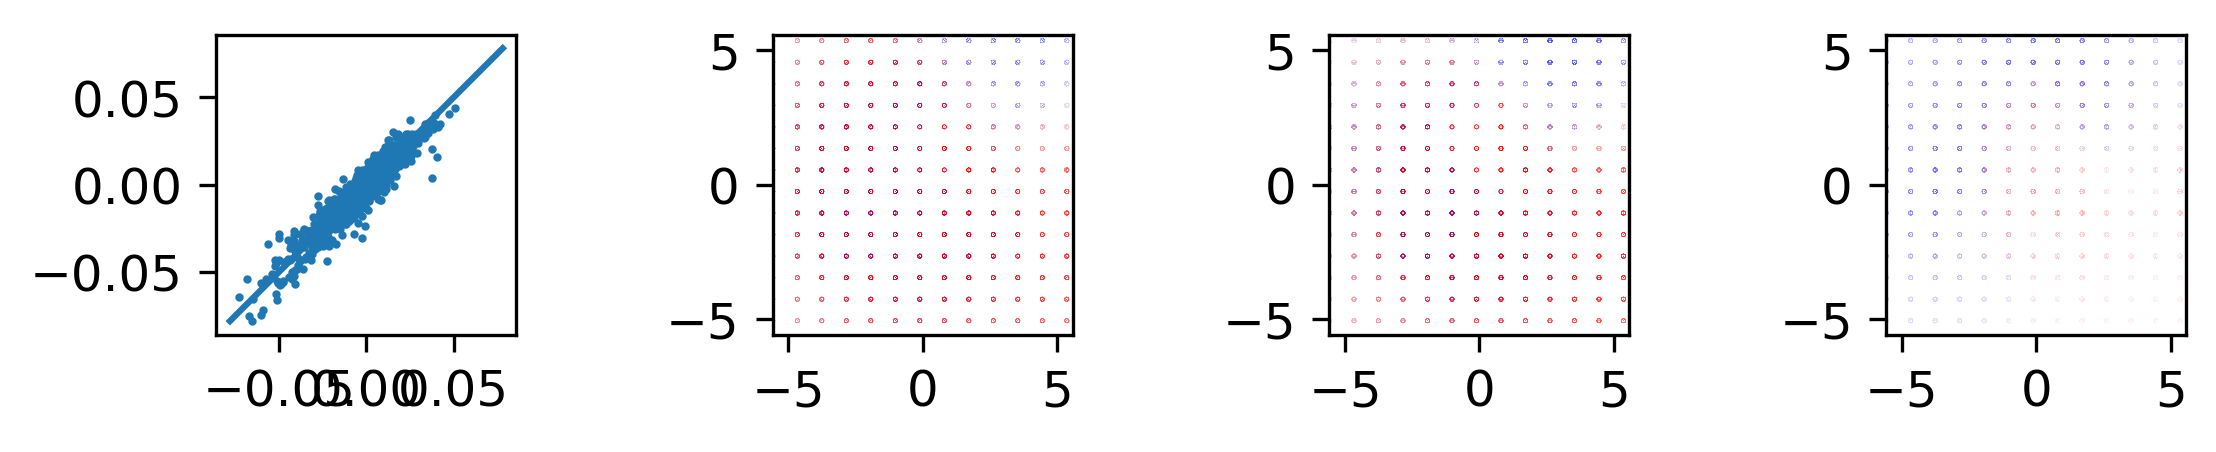

In [44]:
import patchworklib as pw
VMAX = 0.01
xy_ax = pw.Brick()
xy_ax.scatter(batch["esp"], output['esp_pred'], s=1)
max_val = np.sqrt(max(np.max(batch["esp"]**2), np.max(output['esp_pred']**2)))
xy_ax.plot(np.linspace(-max_val, max_val, 100), np.linspace(-max_val, max_val, 100))
xy_ax.set_aspect('equal')

ax_true = pw.Brick()
Npoints = 4150
vdw_surface_min = np.min(batch["vdw_surface"][0], axis=-1)
vdw_surface_max = np.max(batch["vdw_surface"][0], axis=-1)

ax_true.scatter(
    batch["vdw_surface"][0][:Npoints,0], 
batch["vdw_surface"][0][:Npoints,1], 
c=batch["esp"][0][:Npoints],
s=0.01,
    vmin=-VMAX, vmax=VMAX
)
max_val = np.sqrt(max(np.max(batch["esp"]**2), np.max(output['esp_pred']**2)))
# ax.plot(np.linspace(-max_val, max_val, 100), np.linspace(-max_val, max_val, 100))
ax_true.set_aspect('equal')

ax_pred = pw.Brick()

ax_pred.scatter(
    batch["vdw_surface"][0][:Npoints,0], 
batch["vdw_surface"][0][:Npoints,1], 
c=output['esp_pred'][:Npoints],
s=0.01,
    vmin=-VMAX, vmax=VMAX
)
max_val = np.sqrt(max(np.max(batch["esp"]**2), np.max(output['esp_pred']**2)))
# ax.plot(np.linspace(-max_val, max_val, 100), np.linspace(-max_val, max_val, 100))
ax_pred.set_aspect('equal')


ax_diff = pw.Brick()
ax_diff.scatter(
    batch["vdw_surface"][0][:Npoints,0], 
batch["vdw_surface"][0][:Npoints,1], 
c=batch["esp"][0][:Npoints] - output['esp_pred'][:Npoints],
s=0.01,
    vmin=-VMAX, vmax=VMAX
)
ax_diff.set_aspect('equal')

for _ in [ax_pred, ax_true, ax_diff]:
    _.set_xlim(vdw_surface_min[0], -vdw_surface_min[0])
    _.set_ylim(vdw_surface_min[1], -vdw_surface_min[0])


xy_ax | ax_pred | ax_true | ax_diff



In [45]:
output["mono"][0][:int(batch["N"])].sum(axis=-1)


Array([-0.553174  , -0.56327504, -0.54003775,  0.7334167 ,  0.68127525,
        0.6766747 , -0.48318565, -0.54218954, -0.5134257 , -0.40281537,
       -0.19980118, -0.16159002, -0.08209957,  0.27910107,  0.29445225,
        0.28248036,  0.12894624,  0.11133443,  0.11244033,  0.1174085 ,
        0.11375169,  0.12179703,  0.10244989,  0.08393918,  0.10815123,
        0.09397461], dtype=float32)

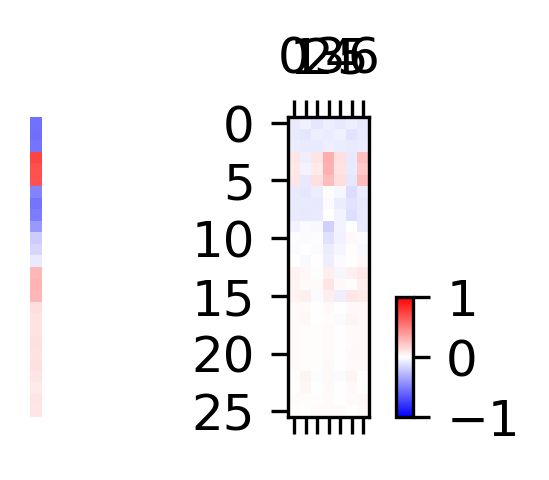

In [46]:
charge_ax = pw.Brick()
charge_ax.matshow(output["mono"][0][:int(batch["N"])],vmin=-1,vmax=1)
scharge_ax = pw.Brick()
scharge_ax.matshow(output["mono"][0][:int(batch["N"])].sum(axis=-1)[:, None],vmin=-1,vmax=1)
# scharge_ax.add_colorbar(vmin=-1,vmax=1)
scharge_ax.axis("off")
f = (scharge_ax | charge_ax)
f.add_colorbar(vmin=-1,vmax=1)

In [52]:
R = output["dipo"][:int(batch["N"])*NDCM]
Z = np.array([8 if _ > 0 else 7 for _ in output["mono"][0][:int(batch["N"])].flatten()])
R.shape, Z.shape
dcm_atoms = ase.Atoms(Z, R)
view(dcm_atoms,  viewer="x3d")

In [ ]:
new_params, valid_loss = train_model(
    key=key, model=model,
    writer=None,
    train_data=train_data, valid_data=valid_data,
    num_epochs=100, learning_rate=5e-4, batch_size=1,
    ndcm=model.n_dcm, esp_w=1000.0,
    restart_params=params if new_params is None else new_params,
)

Preparing batches
..................
